In [1]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

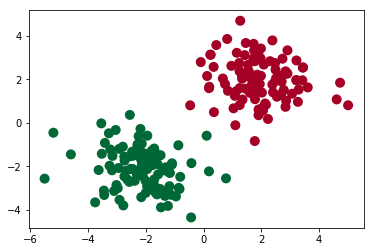

tensor([[ 0.8203,  3.8565,  0.0000],
        [ 0.2483,  3.1311,  0.0000],
        [ 2.4092,  1.4005,  0.0000],
        [ 0.3620,  0.4898,  0.0000],
        [ 1.8758,  1.6382,  0.0000],
        [ 1.7843,  1.0853,  0.0000],
        [ 1.2473,  2.3769,  0.0000],
        [ 2.6747,  1.2848,  0.0000],
        [ 3.2960,  1.5295,  0.0000],
        [ 5.0087,  0.8047,  0.0000],
        [ 3.4242,  1.9549,  0.0000],
        [ 2.9088,  2.2621,  0.0000],
        [ 3.4493,  2.5489,  0.0000],
        [ 2.1631,  0.8325,  0.0000],
        [ 0.2355,  3.1339,  0.0000],
        [ 1.6130,  1.3765,  0.0000],
        [ 1.9072,  1.7392,  0.0000],
        [ 3.0668,  1.3367,  0.0000],
        [ 1.5738,  2.1221,  0.0000],
        [ 1.8963,  3.1692,  0.0000],
        [ 1.3312,  2.1544,  0.0000],
        [ 1.1031, -0.1133,  0.0000],
        [-0.4622,  0.8025,  0.0000],
        [ 1.5682,  2.3722,  0.0000],
        [ 1.1533,  3.2202,  0.0000],
        [ 0.2002,  1.6557,  0.0000],
        [ 2.7787,  1.5094,  0.0000],
 

In [2]:
n_data = torch.ones(100, 2)

x0 = torch.normal(2*n_data, 1)
y0 = torch.zeros(100, 1)

x1 = torch.normal(-2*n_data, 1)
y1 = torch.ones(100, 1)

x = torch.cat((x0, x1)).type(torch.FloatTensor)
y = torch.cat((y0, y1)).type(torch.FloatTensor)

plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

torch.cat((x, y), dim=1)

# GDA Model and Parameters Estimation
$$P(y=1) = \theta = \frac{1}{m} \sum_{i=1}^n 1 \{ y^{(i)} = 1 \}$$

In [3]:
phi1 = (y == 1).sum().float()/200
phi0 = 1 - phi1
phi1

tensor(0.5000)

$$\mu_0 = \frac{\sum_{i=1}^m 1 \{ y^{(i)} = 0 \} x^{(i)}}{\sum_{i=1}^m 1 \{y^{(i)}=0 \} }$$

In [4]:
mu0 = x[(y==0).squeeze(), :].mean(0, keepdim=True)
mu0

tensor([[ 1.9226,  1.9499]])

$$\mu_1 = \frac{\sum_{i=1}^m 1 \{ y^{(i)} = 1 \} x^{(i)}}{\sum_{i=1}^m 1 \{ y^{(i)} = 1 \}}$$

In [5]:
mu1 = x[(y==1).squeeze(), :].mean(0, keepdim=True)
mu1

tensor([[-2.1405, -2.1053]])

$$\sum = diag(1, 1)$$

In [6]:
sigma0 = torch.ones(1, 2)
sigma1 = torch.ones(1, 2)
sigma0

tensor([[ 1.,  1.]])

## Prediction (Test)

In [7]:
a_sample = torch.ones(1, 2)
x_new = torch.normal(-2 * a_sample, 1) # sample x_new ~ Gaussian( mu=(2,2), var=diag(1,1))  (class0)
x_new

tensor([[ 0.4167, -2.4389]])

## Gaussian Distribution

$$p(x; \mu, \sigma) = \frac{1}{ \sqrt{2 \pi | \sigma |}}\text{exp} \Big( -\frac{1}{2} ( x - \mu)^{T} \Sigma^{-1} (x - \mu) \Big) $$

In [8]:
K = 1

def get_k_likelihoods(X, mu, var):
    if var.eq(0).any():
        raise Exception('Variances must be zero')
    
    coeff = 1. / ((2*np.pi * var).prod(dim=1)).sqrt() # (K )
    sigma_inv = 1. / var
    diff = X - mu.unsqueeze(1)
    exponent = -0.5 * (diff ** 2 @ sigma_inv.unsqueeze(2))
    likelihood = coeff.view(K, 1, 1) * torch.exp(exponent)
    return likelihood.squeeze(2)

## likelihood $p(x|y = 1)$

In [9]:
prob1 = get_k_likelihoods(x_new, mu1, sigma1)
prob1

tensor(1.00000e-03 *
       [[ 5.7235]])

## likelihood $p(x|y = 0)$

In [10]:
prob0 = get_k_likelihoods(x_new, mu0, sigma0)
prob0

tensor(1.00000e-06 *
       [[ 3.3633]])

## Decision Rule

$$y = 1 \  \text{if} \   \frac{p(x|y=1) p(y=1)}{p(x|y=0) p(y=0)} > 1$$

In [11]:
(prob1 * phi1) / (prob1 * phi0) > 1 

tensor([[ 0]], dtype=torch.uint8)

## Bayes Rule

$$P(y = 1 | x) = \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0) + p(x|y=1)p(y=1)}$$

In [12]:
p1 = (prob1 * phi1) / ((prob0 * phi0) + (prob1 * phi1))
p1

tensor([[ 0.9994]])

In [13]:
1-p1

tensor(1.00000e-04 *
       [[ 5.8728]])

# Draw Sample fro GDA Model

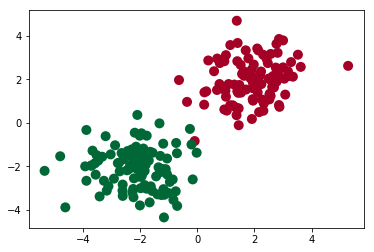

In [14]:
x0 = torch.normal(mu0.repeat(100, 1).data, 1)
y0 = torch.zeros(100, 1)

x1 = torch.normal(mu1.repeat(100, 1).data, 1)
y1 = torch.ones(100, 1)

x_sample = torch.cat((x0, x1)).type(torch.FloatTensor)
y_sample = torch.cat((y0, y1)).type(torch.FloatTensor)

plt.scatter(x_sample.data.numpy()[:, 0], x.data.numpy()[:, 1], c = y_sample.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()